### Verify that pytorch-geometric is correctly installed

If the notebook crashes at the import, there is likely an issue with the version of torch_geometric and torch_sparse being incompatible with the torch version.

In [1]:
## Verify that pytorch-geometric is correctly installed
import torch
import torch_geometric
import torch_sparse
from torch_geometric.nn import MessagePassing
import numpy as np

## Load model
This steps takes a few minutes for the model to download.

**UPDATE**: It is important to set the model in eval mode through `model = model.eval()` to disable random dropout for optimal performance.

In [2]:
import esm
model, alphabet = esm.pretrained.esm_if1_gvp4_t16_142M_UR50()
model = model.to('cuda')
model = model.eval()
#google how to transfer model onto gpu
#something like model = model.to('cuda')

/home/gkannan/anaconda3/envs/inverse-test/lib/python3.9/site-packages/esm/pretrained.py:215: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


In [3]:
torch.cuda.get_device_name(0)

'NVIDIA A40'

In [4]:
!nvidia-smi

Sun Sep  4 19:12:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40          On   | 00000000:01:00.0 Off |                    0 |
|  0%   36C    P0    73W / 300W |   1235MiB / 45634MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A40          On   | 00000000:43:00.0 Off |                    0 |
|  0%   

## Load structure from PDB or CIF files


In [4]:
!wget https://files.rcsb.org/download/6VXX.pdb -P data/    # save this to the data folder in colab

--2022-09-01 06:25:38--  https://files.rcsb.org/download/6VXX.pdb
Resolving files.rcsb.org (files.rcsb.org)... 132.249.210.222
Connecting to files.rcsb.org (files.rcsb.org)|132.249.210.222|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘data/6VXX.pdb.1’

6VXX.pdb.1              [ <=>                ]   2.07M  --.-KB/s    in 0.09s   

2022-09-01 06:25:38 (23.8 MB/s) - ‘data/6VXX.pdb.1’ saved [2175579]



Load chain from PDB file:

In [3]:
fpath = 'data/6M0J.pdb' # .pdb format is also acceptable
chain_id = 'E'
structure = esm.inverse_folding.util.load_structure(fpath, chain_id)
coords, native_seq = esm.inverse_folding.util.extract_coords_from_structure(structure)
print('Native sequence:')
print(native_seq)
print(len(native_seq))

Native sequence:
TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCG
194


## Calculate all possible mutations in a protein

To do this, we define the 'template' sequence - the full sequence of what we want to analyze. For example, this can be the SARS-CoV-2 spike. Then, we define the 'mutating' sequence - the section of that that we want to mutate. This could be the RBD. If both are the same, we mutate and analyze the full RBD.

In [2]:
#Calculating all possible mutants in protein

#RBD:
wuhan = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCG'
alpha = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTYGVGYQPYRVVVLSFELLHAPATVCG'
delta = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTYGVGYQPYRVVVLSFELLHAPATVCG'
beta = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQSYGFQPTYGVGYQPYRVVVLSFELLHAPATVCG'
eta = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCG'
N460K = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSKLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCG'
N460A = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSALKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCG'
N460W = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSWLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCG'
V433R = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCRIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCG'
V433T = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCTIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCG'
N501R = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTRGVGYQPYRVVVLSFELLHAPATVCG'
N501A = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTAGVGYQPYRVVVLSFELLHAPATVCG'
E471R = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTRIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCG'
S477N = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGNTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCG'
L368Y = 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVYYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCG'
A419Y = 


wt_6vxx_spike = 'AYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVNCTFEYVSFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKGNYNYLYRKPFERDIYFPLQSYGFQPTNVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTSQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDPPEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDS'
wt_6vxx_ntd = 'AYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVNCTFEYVSFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQT'

## Why am I not using the full RBD/spike/etc.? The model won't allow me - it only takes into account lengths if they match the native sequence in the pdb.


chosenseq = L368Y  #The template sequence - i.e. if you want to run full spike but mutate RBD, this is full spike.
chosenseqname = 'L368Y'  
choosemutseq = L368Y   #The sequence you want to mutate - for example, RBD in full spike
startpoint = 0   #The AA residue (indexed at 0) that the mutated sequence starts at in template.
true_index = 333 #The true start of the sequence in the FL spike protein; for RBD this is 333, for NTD this is 14
likelihoodorlog = 'likelihood' #Use likelihood or log likelihood for analysis
multichain = True

seq = list(chosenseq)
aalist = ["A","R","N","D","C","E","Q","G","H","I","L","K","M","F","P","S","T","W","Y","V"]

seq2 = seq.copy()
muts = {'WT': "".join(seq)}

for i in range(startpoint,startpoint+len(choosemutseq)):
  for j in aalist:
    seq2[i] = j
    muts.update({str(i)+j:"".join(seq2)})
    seq2 = seq.copy()


In [8]:
#Saving in /data folder

if multichain == True:
    if chosenseqname == 'wuhan':
        output_path = 'data/all_mutant_list_mc.txt'
    else:
        output_path = 'data/all_mutant_list_'+chosenseqname+'_mc.txt'
else:
    if chosenseqname == 'wuhan':
        output_path = 'data/all_mutant_list.txt'
    else:
        output_path = 'data/all_mutant_list_'+chosenseqname+'.txt'
        
output_file = open(output_path,'w')

for seq_id, sequence in muts.items():
    identifier_line = ">" + seq_id + "\n"
    output_file.write(identifier_line)
    sequence_line = sequence + "\n"
    output_file.write(sequence_line)
    
#Close the file when we're done
output_file.close()

## Conditional sequence log-likelihoods for given backbone coordinates

The log-likelihood scores could be used to predict mutational effects. See also our [script](https://github.com/facebookresearch/esm/tree/main/examples/inverse_folding#scoring-sequences) for batch scoring,

In [9]:
if multichain == True:
    if chosenseqname == 'wuhan':
        mutantlistname = 'data/all_mutant_list_mc.txt'
        ll_list_name = 'data/mutant_list_lls_mc.csv'
    else:
        mutantlistname = 'data/all_mutant_list_'+chosenseqname+'_mc.txt'
        ll_list_name = 'data/mutant_list_lls'+chosenseqname+'_mc.csv'
else:
    if chosenseqname == 'wuhan':
        mutantlistname = 'data/all_mutant_list.txt'
        ll_list_name = 'data/mutant_list_lls.csv'
    else:
        mutantlistname = 'data/all_mutant_list_'+chosenseqname+'.txt'
        ll_list_name = 'data/mutant_list_lls'+chosenseqname+'.csv'
if multichain == True:
    !python score_log_likelihoods2.py data/6M0J.pdb \
        $mutantlistname --chain E --multichain-backbone\
        --outpath $ll_list_name
else:
    !python score_log_likelihoods2.py data/6M0J.pdb \
        $mutantlistname --chain E\
        --outpath $ll_list_name

/home/gkannan/anaconda3/envs/inverse-test/lib/python3.9/site-packages/esm/pretrained.py:215: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(
Native sequence loaded from structure file:
TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCG


Native sequence
Log likelihood: -1.21
Perplexity: 3.35

Scoring variant sequences from sequence file..

100%|███████████████████████████████████████| 3881/3881 [32:52<00:00,  1.97it/s]
Results saved to data/mutant_list_llsL368Y_mc.csv


## Analysis

At this point we have all mutations & the associated log-likelihood outputs from the model.

In [10]:
#Read in data, make new dataframes

import pandas as pd
import numpy as np

aalist = ["A","R","N","D","C","E","Q","G","H","I","L","K","M","F","P","S","T","W","Y","V"]

#Read in data as dataframe

if chosenseqname == 'alpha':
    chosenseqname = 'N501Y'
if multichain == True:
    chosenseqname += '_mc'
    
    
if multichain == True:
    all_mutants_df=pd.read_table("data/all_mutant_list_mc.txt", sep=" ", header=None)
else:
    all_mutants_df=pd.read_table("data/all_mutant_list.txt", sep=" ", header=None)

all_mutants_Variant_df=data=pd.read_table("data/all_mutant_list_"+chosenseqname+".txt", sep=" ", header=None)
all_mutants_df.insert(1,'sequence','')
all_mutants_Variant_df.insert(1,'sequence','')


#Split dataframe into mutation & sequence

mutants_df = pd.DataFrame({'mutation':all_mutants_df[0].iloc[::2].values, 'sequence':all_mutants_df[0].iloc[1::2].values})
Variant_df = pd.DataFrame({'mutation':all_mutants_Variant_df[0].iloc[::2].values, 'sequence':all_mutants_Variant_df[0].iloc[1::2].values})

#Read in mutation & log likelihood
if multichain == True:
    mlistll=pd.read_csv("data/mutant_list_lls_mc.csv", sep=",", header=0)
else:
    mlistll=pd.read_csv("data/mutant_list_lls.csv", sep=",", header=0)

if chosenseqname == 'N501Y':
    mlistVariantll=data=pd.read_csv("data/mutant_list_lls_"+chosenseqname+".csv", sep=",", header=0)
else:
    mlistVariantll=data=pd.read_csv("data/mutant_list_lls"+chosenseqname+".csv", sep=",", header=0)


In [11]:
#Add likelihoods to main dataframes, and normalize

mutants_df['log likelihood'] = mlistll['log_likelihood']
Variant_df['log likelihood'] = mlistVariantll['log_likelihood']

mutants_df['likelihood'] = np.exp(mutants_df['log likelihood'])# -np.exp(-1.1953586339950562) #Centers them around 0 = basis sequence
Variant_df['likelihood'] = np.exp(Variant_df['log likelihood'])# -np.exp(-1.2073875665664673)


In [12]:
### See how model computes log likelihood

In [13]:
#Distance metric

Variant_df['ll_ratio'] = (Variant_df['log likelihood'] - -1.2073875665664673) - (mutants_df['log likelihood'] - -1.1953586339950562)



<AxesSubplot:>

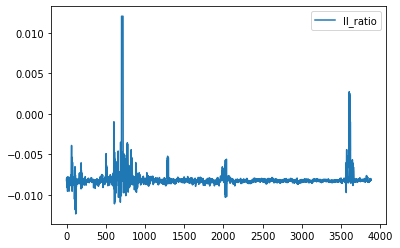

In [14]:
#Plot ratio as is

Variant_df.plot(y='ll_ratio')

In [15]:
#Split > off of mutation
Variant_df['mutation'] = Variant_df['mutation'].map(lambda x: x.lstrip('>'))
mutants_df['mutation'] = mutants_df['mutation'].map(lambda x: x.lstrip('>'))

#Copy mutation to column index

Variant_df['index']=Variant_df['mutation']
mutants_df['index']=mutants_df['mutation']

#Remove wild type sequence (first one)

Variant_df_noWT = Variant_df.copy()
Variant_df_noWT = Variant_df_noWT.iloc[1: , :]

mutants_df_noWT = mutants_df.copy()
mutants_df_noWT = mutants_df_noWT.iloc[1: , :]

#Remove index from mutation column, and amino acid from index column.
#This gives us one column defining index & one column defining the amino acid at that position.

Variant_df_noWT['mutation'] = Variant_df_noWT['mutation'].str.replace('\d+', '')
Variant_df_noWT['index'] = Variant_df_noWT['index'].str.replace(str(aalist), '')

mutants_df_noWT['mutation'] = mutants_df_noWT['mutation'].str.replace('\d+', '')
mutants_df_noWT['index'] = mutants_df_noWT['index'].str.replace(str(aalist), '')


/tmp/ipykernel_920686/3706814439.py:21: FutureWarning: The default value of regex will change from True to False in a future version.
  Variant_df_noWT['mutation'] = Variant_df_noWT['mutation'].str.replace('\d+', '')
/tmp/ipykernel_920686/3706814439.py:22: FutureWarning: The default value of regex will change from True to False in a future version.
  Variant_df_noWT['index'] = Variant_df_noWT['index'].str.replace(str(aalist), '')
/tmp/ipykernel_920686/3706814439.py:24: FutureWarning: The default value of regex will change from True to False in a future version.
  mutants_df_noWT['mutation'] = mutants_df_noWT['mutation'].str.replace('\d+', '')
/tmp/ipykernel_920686/3706814439.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  mutants_df_noWT['index'] = mutants_df_noWT['index'].str.replace(str(aalist), '')


In [16]:
#Shift index to true index; i.e. change position 0 to position 333 for RBD.

true_index = 333

Variant_df_noWT['index'] = pd.to_numeric(Variant_df_noWT['index'])
Variant_df_noWT['index'] = Variant_df_noWT['index'] + true_index

#result here is a pivot table of ll_ratio, other pivot tables are of just likelihood

result = Variant_df_noWT.pivot_table(index='mutation', columns='index', values='ll_ratio',sort=False)

mutants_df_noWT['index'] = pd.to_numeric(mutants_df_noWT['index'])
mutants_df_noWT['index'] = mutants_df_noWT['index'] + true_index

#Create a pivot table w/ index on x and mutation on y

result_mut = mutants_df_noWT.pivot_table(index='mutation', columns='index', values=likelihoodorlog,sort=False)

result_Variant = Variant_df_noWT.pivot_table(index='mutation', columns='index', values=likelihoodorlog,sort=False)


In [17]:
#NA out mutation

import re
namutpos = re.sub('[^0-9]','', chosenseqname)
namutpos = int(namutpos)

result_Variant[namutpos] = np.nan

In [18]:
#Ship to excel

result_Variant.to_excel('data/result_Variant.xlsx')

# Comparing Eta and Wuhan

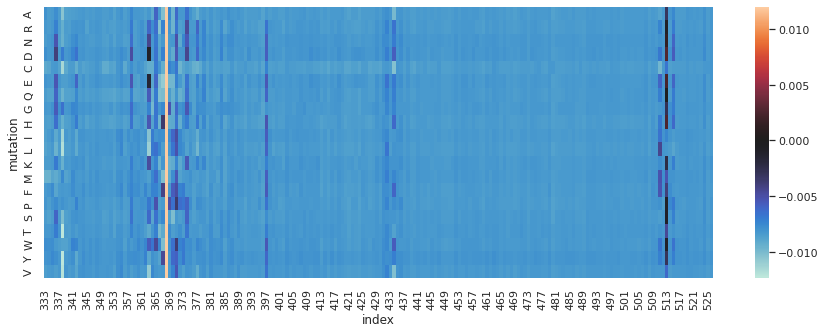

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc = {'figure.figsize':(15,5)})

sns.heatmap(result, annot=False, cmap='icefire',center=0)
plt.show()

#Heatmap of ll_ratio

In [20]:
#### NA THE 501 POSITION ABOVE

### Ian Wilson group Nat Comm Flu epistasis deep mutational scanning 2020 7 diff flu-HA backgrounds all possible amino acid changes at like 6 sites

### make sure i'm using gpu compute lmao

### Figure out if JSD is using softmax to make it probabilities -> making it jensen shannon

<AxesSubplot:xlabel='index'>

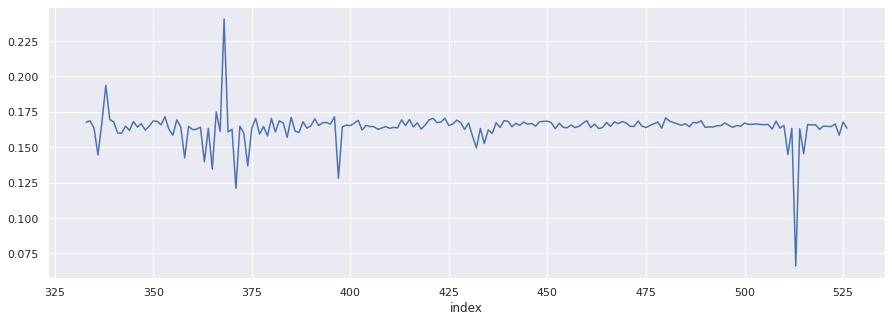

In [21]:
#Quick & dirty quantification - vertical sum of absolute values of heatmap

result_abs = abs(result)
resultsum = result_abs.sum()
resultsum.plot()

# Wuhan/Variants Heatmaps

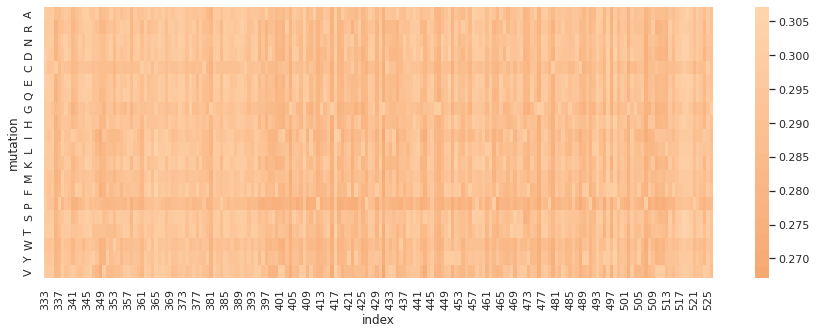

In [22]:
sns.set(rc = {'figure.figsize':(15,5)})

sns.heatmap(result_mut, annot=False, cmap='icefire',center=0)
plt.show()
#Wuhan

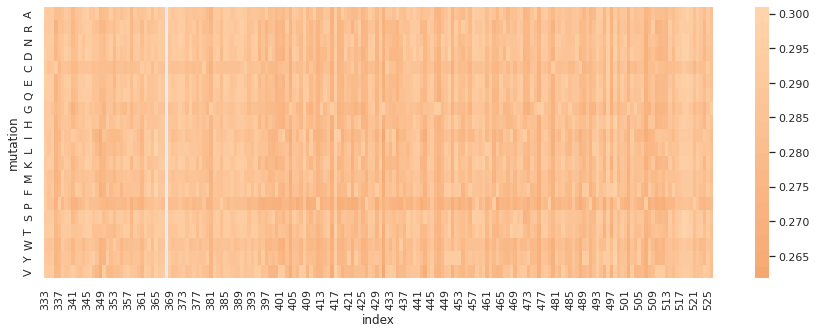

In [23]:
sns.set(rc = {'figure.figsize':(15,5)})

sns.heatmap(result_Variant, annot=False, cmap='icefire',center=0)
plt.show()
#N501Y

Jensen-shannon divergence

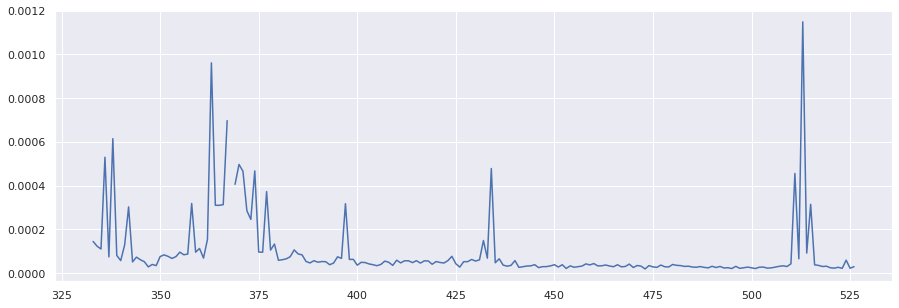

In [24]:
#Cycle through all positions, calculate JSD between results_Variant and result_mutant at each position
import scipy

jsd_Variant = []
columns=[]

for column in result_Variant:
    columns.append(column)
    jsd_Variant.append(scipy.spatial.distance.jensenshannon(result_Variant[column],result_mut[column]))
    
plt.plot(columns,jsd_Variant)

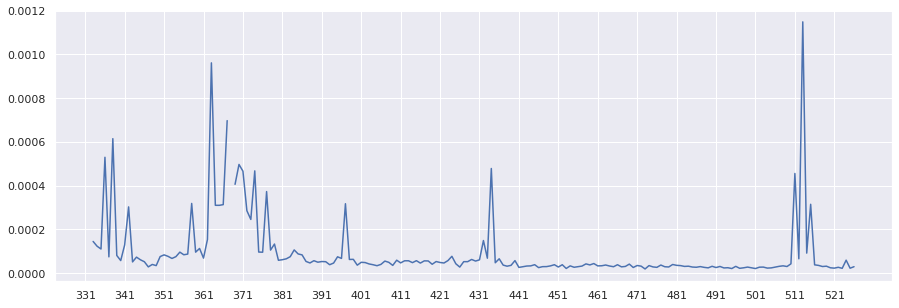

In [25]:
#Cycle through all positions, calculate JSD between results_Variant and result_mutant at each position

#This time did absolute values of each vector.

#You want JSD between pairs of columns.

import scipy

jsd_Variant = []
columns = []

for column in result_Variant:
    columns.append(column)
    jsd_Variant.append(scipy.spatial.distance.jensenshannon(result_Variant[column],result_mut[column]))
    
plt.plot(columns,scipy.spatial.distance.jensenshannon(abs(result_Variant),abs(result_mut),axis=0))

freq_x = 10

plt.xticks(np.arange(331, 531, freq_x))
plt.show()

In [26]:
#We want some type of up/down SCORE; i.e. is this positive epistasis or negative epistasis?

#One idea to do this is to subtract or divide all likelihoods in ancestral strain positionxmutation matrix from variant
# positionxmutation matrix. Then ask questions (1) is it mean good or bad, (2) are any at all good

#This didn't really work, see gokul gilead notebook page

index
513    0.990729
363    0.987060
367    0.984567
371    0.984504
336    0.984177
511    0.983673
374    0.983663
365    0.983501
358    0.983186
369    0.983139
397    0.982873
370    0.982512
434    0.982507
515    0.982437
377    0.982104
dtype: float64


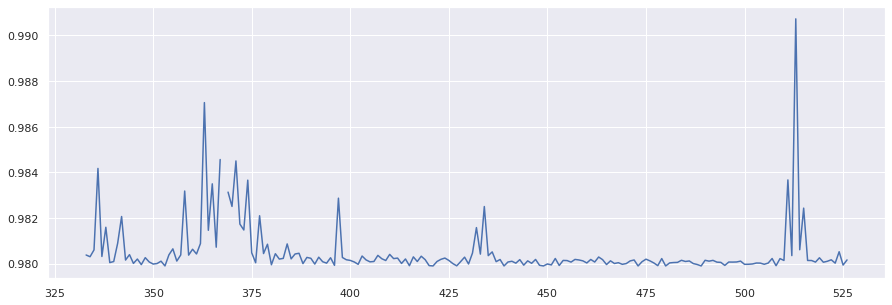

In [27]:
result_diff = result_Variant/result_mut

(result_diff > 1).any()


with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(result_diff.max().nlargest(n=15))
    
plt.plot(result_diff.max())


What does everything mean?
JSD is a measure of the degree of epistasis.
Max is a measure of is there a good mutation at that point

In [28]:
jsd_df = pd.Series(data=jsd_Variant,index=columns)

In [29]:
jsd_df.nlargest(10).index

Int64Index([513, 363, 367, 338, 336, 370, 434, 374, 371, 511], dtype='int64')

In [30]:
jsd_df.nlargest(10)

513    0.001149
363    0.000962
367    0.000697
338    0.000615
336    0.000530
370    0.000497
434    0.000479
374    0.000468
371    0.000466
511    0.000456
dtype: float64

In [31]:
result_Variant.max()[jsd_df.nlargest(10).index]

513    0.292127
363    0.295076
367    0.293291
338    0.292567
336    0.292127
370    0.292127
434    0.292127
374    0.292127
371    0.292127
511    0.292127
dtype: float64

In [32]:
np.exp(-1.2)

0.30119421191220214

In [33]:
jsd_df = pd.Series(data=jsd_Variant,index=columns)
result_Variant.max()[jsd_df.nlargest(10).index]

513    0.292127
363    0.295076
367    0.293291
338    0.292567
336    0.292127
370    0.292127
434    0.292127
374    0.292127
371    0.292127
511    0.292127
dtype: float64